
# Changing MLP Architecture and Fitting

This example is nearly identical to the Synthetic Data fit, however we use
a different neural network architecture in hopes of obtaining a better spectra fitting.
The same set-up using the Mann model under the Kaimal spectra is used here as in other synthetic 
data fitting examples. The only difference here is in the neural network architecture. 
Although certain combinations of activation functions, such as ``GELU`` result in considerably
improved spectra fitting and terminal loss values, the resulting eddy lifetime functions are 
usually non-physical. 

See again the [original DRD paper](https://arxiv.org/abs/2107.11046).


## Import packages

First, we import the packages we need for this example. Additionally, we choose to use
CUDA if it is available.



In [1]:
import torch
import torch.nn as nn

from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

The following cell sets the necessary physical constants, including the characteristic
scales for non-dimensionalization, the reference velocity, and the domain.
We consider the range $\mathcal{D} = [0.1, 100]$ and sample the data points
$f_j \in \mathcal{D}$ using a logarithmic grid of $20$ nodes.



In [2]:
# Scales associated with Kaimal spectrum
L = 0.59
Gamma = 3.9
sigma = 3.2

# Reference velocity
Uref = 21.0


domain = torch.logspace(-1, 2, 20)

%%
Now, we construct our ``CalibrationProblem``.

Compared to the first Synthetic Fit example, as noted already, we are using
a more complicated neural network architecture. This time, specifically, our
network will have 4 layers of width 10, 20, 20, 10 respectively, and we
use both ``GELU`` and ``RELU`` activations. We have
prescribed more Wolfe iterations.
Finally, this task is considerably more difficult than before since the exponent of
the eddy lifetime function $\nu$ is to be learned. Much more training
may be necessary to obtain a close fit to the eddy lifetime function. Interestingly,
learning this parameter results in models that more accurately describe the spectra of
Mann turbulence than using the Mann model itself.



In [3]:
pb = CalibrationProblem(
    nn_params=NNParameters(
        nlayers=4,
        # Specifying the activations is done similarly.
        hidden_layer_sizes=[10, 20, 20, 10],
        activations=[nn.ReLU(), nn.GELU(), nn.GELU(), nn.ReLU()],
    ),
    prob_params=ProblemParameters(nepochs=25, wolfe_iter_count=20),
    loss_params=LossParameters(alpha_pen2=1.0, beta_reg=1.0e-5),
    phys_params=PhysicalParameters(
        L=L, Gamma=Gamma, sigma=sigma, Uref=Uref, domain=domain
    ),
    logging_directory="runs/synthetic_fit_deep_arch",
    device=device,
)

## Data Generation
In the following cell, we construct our $k_1$ data points grid and
generate the values. ``Data`` will be a tuple ``(<data points>, <data values>)``.
It is worth noting that the second element of each tuple in ``DataPoints`` is the
corresponding reference height, which we have chosen to be uniformly $1$.



In [4]:
k1_data_pts = domain
DataPoints = [(k1, 1) for k1 in k1_data_pts]

Data = OnePointSpectraDataGenerator(data_points=DataPoints).Data

## Training
Now, we fit our model. ``CalibrationProblem.calibrate()`` takes the tuple ``Data``
which we just constructed and performs a typical training loop.



In [5]:
optimal_parameters = pb.calibrate(data=Data)

Initial loss: 0.09212132602722375


  0%|                                                                                          | 0/25 [00:00<?, ?it/s]

  4%|███▎                                                                              | 1/25 [00:05<02:05,  5.22s/it]

  8%|██████▌                                                                           | 2/25 [00:09<01:42,  4.47s/it]

 12%|█████████▊                                                                        | 3/25 [00:13<01:34,  4.31s/it]

 16%|█████████████                                                                     | 4/25 [00:17<01:30,  4.30s/it]

 20%|████████████████▍                                                                 | 5/25 [00:21<01:24,  4.24s/it]

 24%|███████████████████▋                                                              | 6/25 [00:25<01:18,  4.15s/it]

 28%|██████████████████████▉                                                           | 7/25 [00:29<01:14,  4.15s/it]

 32%|██████████████████████████▏                                                       | 8/25 [00:33<01:09,  4.09s/it]

 36%|█████████████████████████████▌                                                    | 9/25 [00:37<01:05,  4.10s/it]

 40%|████████████████████████████████▍                                                | 10/25 [00:42<01:01,  4.11s/it]

 44%|███████████████████████████████████▋                                             | 11/25 [00:46<00:56,  4.07s/it]

 48%|██████████████████████████████████████▉                                          | 12/25 [00:50<00:53,  4.09s/it]

 52%|██████████████████████████████████████████                                       | 13/25 [00:54<00:49,  4.10s/it]

 56%|█████████████████████████████████████████████▎                                   | 14/25 [00:58<00:45,  4.11s/it]

 60%|████████████████████████████████████████████████▌                                | 15/25 [01:02<00:41,  4.12s/it]

 64%|███████████████████████████████████████████████████▊                             | 16/25 [01:06<00:37,  4.12s/it]

 68%|███████████████████████████████████████████████████████                          | 17/25 [01:10<00:32,  4.07s/it]

 72%|██████████████████████████████████████████████████████████▎                      | 18/25 [01:14<00:28,  4.04s/it]

 76%|█████████████████████████████████████████████████████████████▌                   | 19/25 [01:18<00:24,  4.01s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 20/25 [01:22<00:19,  4.00s/it]

 84%|████████████████████████████████████████████████████████████████████             | 21/25 [01:26<00:16,  4.08s/it]

 88%|███████████████████████████████████████████████████████████████████████▎         | 22/25 [01:30<00:12,  4.09s/it]

 92%|██████████████████████████████████████████████████████████████████████████▌      | 23/25 [01:34<00:08,  4.05s/it]

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 24/25 [01:39<00:04,  4.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [01:43<00:00,  4.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [01:43<00:00,  4.12s/it]

Spectra fitting concluded with final loss: 0.0031031298868164684


## Plotting
Lastly, we'll use built-in plotting utilities to see the fit result.



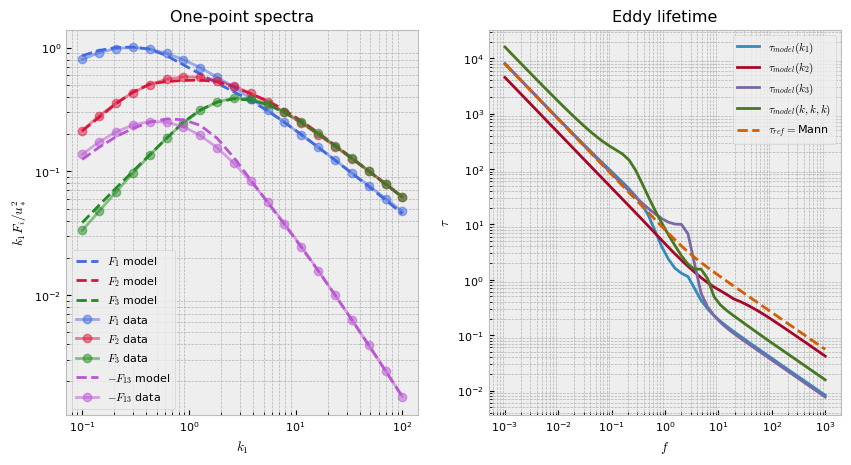

In [6]:
pb.plot()

This plots the loss function terms as specified, each multiplied by the
respective coefficient hyperparameter. The training logs can be accessed from the logging directory
with Tensorboard utilities, but we also provide a simple internal utility for a single
training log plot.



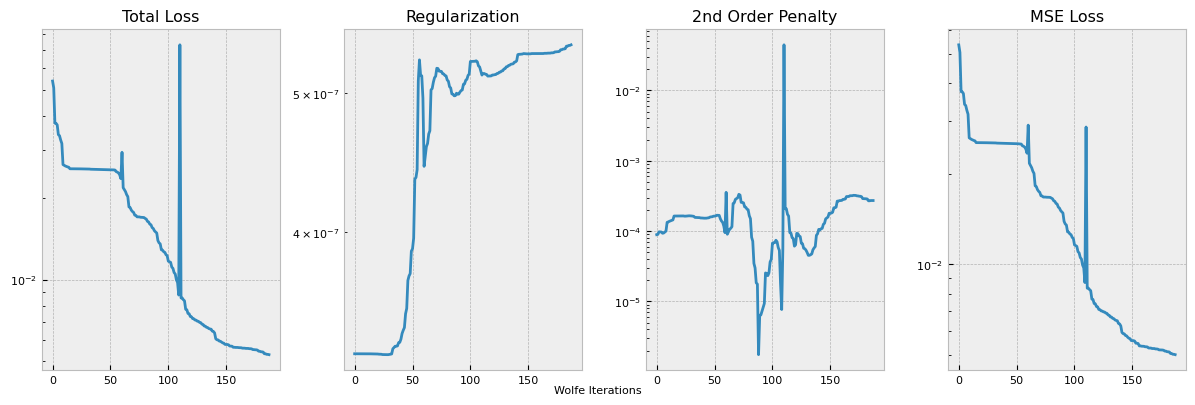

In [7]:
pb.plot_losses(run_number=0)